In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def _get_fourier_filter(size, filter_name):
    """Construct the Fourier filter.
    This computation lessens artifacts and removes a small bias as
    explained in [1], Chap 3. Equation 61.
    Parameters
    ----------
    size : int
        filter size. Must be even.
    filter_name : str
        Filter used in frequency domain filtering. Filters available:
        ramp, shepp-logan, cosine, hamming, hann. Assign None to use
        no filter.
    Returns
    -------
    fourier_filter: ndarray
        The computed Fourier filter.
    References
    ----------
    .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
           Imaging", IEEE Press 1988.
    """
    n = torch.cat((torch.arange(1, size / 2 + 1, 2, dtype=int),
                           torch.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = torch.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (torch.pi * n) ** 2

    # Computing the ramp filter from the fourier transform of its
    # frequency domain representation lessens artifacts and removes a
    # small bias as explained in [1], Chap 3. Equation 61
    fourier_filter = 2 * torch.real(torch.fft.fft(f))         # ramp filter
    if filter_name == "ramp":
        pass
    elif filter_name == "shepp-logan":
        # Start from first element to avoid divide by zero
        omega = torch.pi * torch.fft.fftfreq(size)[1:]
        fourier_filter[1:] *= torch.sin(omega) / omega
    elif filter_name == "cosine":
        freq = torch.linspace(0, torch.pi, size, endpoint=False)
        cosine_filter = torch.fft.fftshift(torch.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == "hamming":
        fourier_filter *= torch.fft.fftshift(torch.hamming(size))
    elif filter_name == "hann":
        fourier_filter *= torch.fft.fftshift(torch.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1

    return fourier_filter[:, None]

def rampfilter(size):
    n = np.concatenate((np.arange(1, size / 2 + 1, 2, dtype=int),
                        np.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = np.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2
    return torch.tensor(2 * np.real(np.fft.fft(f)) )

In [3]:
class fbp(torch.nn.Module):
    ''' 
    Filtered Backprojection
    Args:
        n_angles (int): number of projection angles for filtered backprojection (default: 1000)
        image_size (int): edge length of input image (default: 400)
        circle (bool): project image values outside of circle to zero (default: False)
        filtered (bool): apply filter (default: True)
        device: (str): device can be either "cuda" or "cpu" (default: cuda)
    '''
    def __init__(self, n_angles=1000, image_size=400, circle = False, filtered=True, device="cpu"):
        super().__init__()
        self.image_size=image_size
        det_count = image_size
        self.step_size = image_size/det_count
        self.n_angles = n_angles
        self.circle=circle
        self.filtered=filtered
        # padding values
        projection_size_padded = max(64, int(2 ** (2 * torch.tensor(det_count)).float().log2().ceil()))
        self.pad_width = (projection_size_padded - det_count)
        #filter
        self.filter = rampfilter(projection_size_padded).to(device)
        # get angles 
        thetas = torch.linspace(0, np.pi-(np.pi/n_angles), n_angles)[:,None,None] 
        # get grid [-1,1]
        grid_y, grid_x = torch.meshgrid(torch.linspace(-1,1,image_size), torch.linspace(-1,1,image_size))
        # get rotated grid
        tgrid = (grid_x*thetas.cos() - grid_y*thetas.sin()).unsqueeze(-1)
        y = torch.ones_like(tgrid) * torch.linspace(-1,1,n_angles)[:,None,None,None]
        self.grid = torch.cat((y,tgrid),dim=-1).view(self.n_angles * self.image_size, self.image_size, 2)[None].to(device)
        self.reconstruction_circle = (grid_x ** 2 + grid_y ** 2) <= 1

    def forward(self, input):
        '''Apply (filtered) backprojection on input sinogramm.
        Args:
            image (torch.tensor, (bzs, 1, W, angles)): sinogramm
        Returns:
            out (torch.tensor, (bzs, 1, W, H)): reconstructed image 
        '''

        bsz, _, det_count, _ = input.shape
        input = input.double()
        if self.filtered:
            # pad input
            padded_input = torch.nn.functional.pad(input, [0, 0, 0, self.pad_width], mode='constant', value=0)
            # apply filter
            projection = torch.fft.fft(padded_input,dim=2) * self.filter[:,None].double()
            radon_filtered = torch.real(torch.fft.ifft(projection,dim=2))[:, :, :det_count, :]
        else:
            radon_filtered = input
        # reconstruct
        grid = self.grid.repeat(bsz,1,1,1).double()
        reconstructed = torch.nn.functional.grid_sample(radon_filtered, grid, mode="bilinear", padding_mode='zeros', align_corners=True)
        reconstructed = reconstructed.view(bsz, self.n_angles, 1, self.image_size, self.image_size).sum(1)
        reconstructed = reconstructed/self.step_size
        # circle
        if self.circle:
            reconstructed_circle = self.reconstruction_circle.repeat(bsz,1,1,1).double()
            reconstructed[reconstructed_circle==0] = 0.
        return reconstructed  * np.pi / (2 * self.n_angles)

In [37]:
# Makes sure the hardware is available
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
import numpy as np
from skimage import io
from tqdm import tqdm


PATH_TO_IMAGE =  '../data_store/2022-10-10_1433_testrecon/cut.tif'
im = io.imread(PATH_TO_IMAGE)
im = np.moveaxis(im, 0, -1)
print(type(im))
# Change dtype as PyTorch does not support uint16
im = np.ndarray.astype(im, 'float64')
im = torch.tensor(im, dtype=torch.float64)

True
True
<class 'numpy.ndarray'>


(bzs, 1, W, angles)

In [38]:
im.shape

torch.Size([1392, 932, 400])

In [39]:
n_angles, H, W = im.shape

In [40]:
input = im.permute((1,2,0)).unsqueeze(1)[:1]
input.shape

torch.Size([1, 1, 400, 1392])

In [23]:
inv_radon = fbp(n_angles, image_size=W, device='cpu')
reconstruction = inv_radon.forward(input)

In [24]:
reconstruction.shape

torch.Size([1, 1, 932, 932])

In [25]:
im.shape

torch.Size([400, 1392, 932])

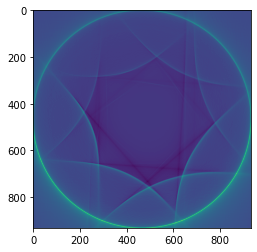

In [28]:
plt.imshow(reconstruction[0,0])

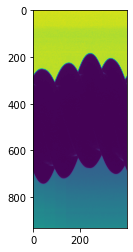

In [41]:
plt.imshow(im[0])